# MNIST import

In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import torch

from pathlib import Path

from itertools import chain

from tqdm import tqdm

In [15]:
dataset_train = MNIST(root=Path('data/'), download=True, train = True, transform=ToTensor())
train_dataloader = DataLoader(
    dataset_train,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)
dataset_test = MNIST(root=Path('data/'), download=True, train=False, transform=ToTensor())
test_dataloader = DataLoader(
    dataset_test,
    batch_size=10000,
)

# Eucl

## Eucl model definition

In [21]:
euclidean_encoder = torch.nn.Sequential(
    torch.nn.Linear(in_features=28*28, out_features=100),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=100, out_features=2),
    torch.nn.ReLU()
).cuda()

euclidean_decoder = torch.nn.Sequential(
    torch.nn.Linear(in_features=2, out_features=100),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=100, out_features=28*28),
    torch.nn.ReLU(),
).cuda()

In [22]:
optimizer = torch.optim.Adam(params = chain(euclidean_encoder.parameters(), euclidean_decoder.parameters()),
                             lr = 1e-3, weight_decay=1e-4)

criterion = torch.nn.MSELoss()

epochs = 10

In [23]:
pbar = tqdm(range(epochs))

for epoch in pbar:
    train_losses = []
    for data, label in train_dataloader:
        optimizer.zero_grad()
        euclidean_encoder.zero_grad()
        euclidean_decoder.zero_grad()

        data = data.flatten(start_dim=1).cuda()
        latent = euclidean_encoder(data)
        recon = euclidean_decoder(latent)

        loss = criterion(data, recon)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.cpu().detach().numpy())
    
    tl = sum(train_losses)/len(train_losses)

    for data, _ in test_dataloader:
        with torch.no_grad():
            data = data.flatten(start_dim=1).cuda()
            recon = euclidean_decoder(euclidean_encoder(data))
            loss = criterion(data, recon)
    pbar.set_description(f"Train loss: {tl:.4f}, Test loss: {loss.item():.4f}")

Train loss: 0.0486, Test loss: 0.0485: 100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


# Hyperbolic autoencoders

In [48]:
import sys

sys.path.append('CartanNetworks/code')

from models import HyperbolicNetwork
from layers import DmELU

hyp_encoder = HyperbolicNetwork(size=28*28, layer_size_list=[100+1, 2], activation=DmELU, head=torch.nn.Identity()).cuda()
hyp_decoder = HyperbolicNetwork(size=2, layer_size_list=[10 + 1, 28*28 + 1], activation=DmELU, head=torch.nn.Identity()).cuda()

In [51]:
from geoopt.optim import RiemannianAdam

optimizer = RiemannianAdam(params = chain(hyp_encoder.parameters(), hyp_decoder.parameters()), lr=1e-3, weight_decay = 1e-4)


pbar = tqdm(range(epochs))

for epoch in pbar:
    train_losses = []
    for data, label in train_dataloader:
        optimizer.zero_grad()
        hyp_encoder.zero_grad()
        hyp_decoder.zero_grad()

        data = data.flatten(start_dim=1).cuda()
        latent = hyp_encoder(data)
        recon = hyp_decoder(latent)

        loss = criterion(data, recon[..., 1:]) # only take the fiber

        loss.backward()
        optimizer.step()

        train_losses.append(loss.cpu().detach().numpy())
    
    tl = sum(train_losses)/len(train_losses)

    for data, _ in test_dataloader:
        with torch.no_grad():
            data = data.flatten(start_dim=1).cuda()
            recon = hyp_decoder(hyp_encoder(data))
            loss = criterion(data, recon[..., 1:])
    pbar.set_description(f"Train loss: {tl:.4f}, Test loss: {loss.item():.4f}")


Train loss: 0.0524, Test loss: 0.0519: 100%|██████████| 10/10 [03:24<00:00, 20.43s/it]


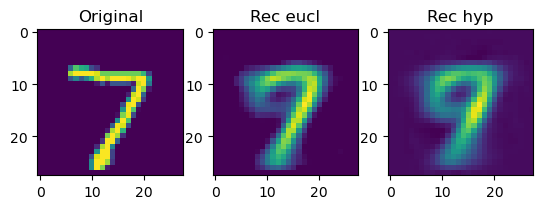

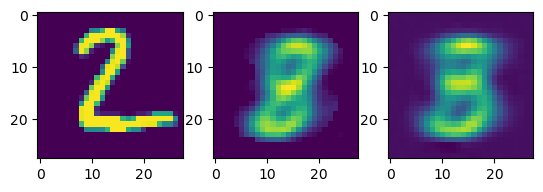

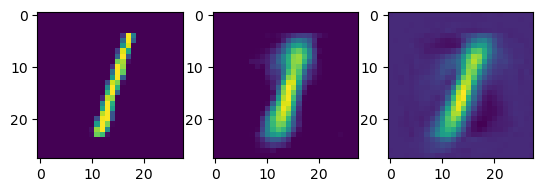

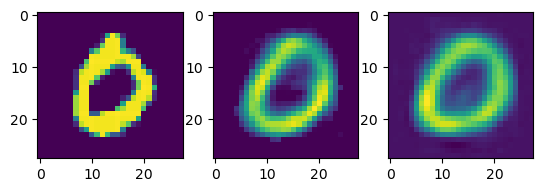

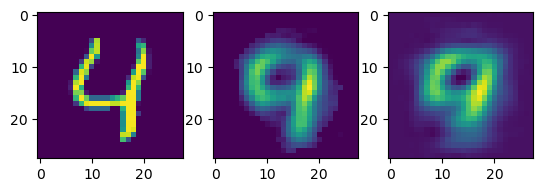

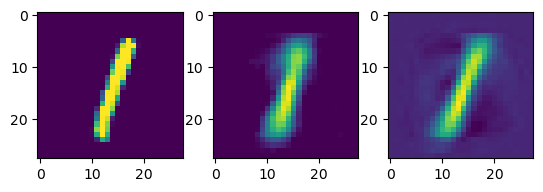

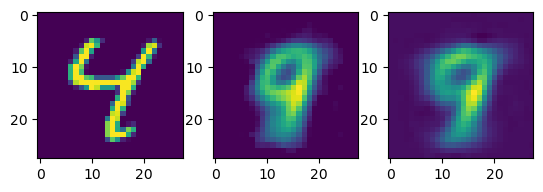

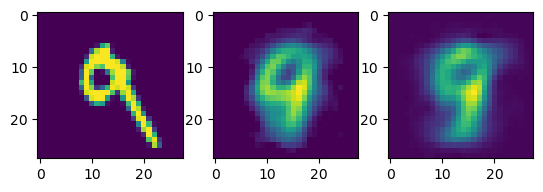

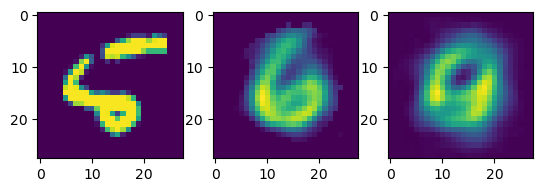

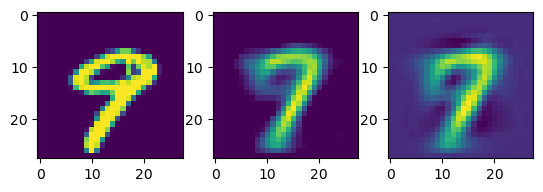

In [52]:
import matplotlib.pyplot as plt

for item, _ in list(iter(test_dataloader)):
    for image in range(10):
        fig = plt.figure()
        axes = fig.subplots(nrows=1, ncols=3)
        axes[0].imshow(item[image,0,...].detach().cpu().numpy())
        axes[1].imshow(euclidean_decoder(euclidean_encoder(item.flatten(start_dim=1).cuda()))[image].reshape(28,28).cpu().detach().numpy())
        axes[2].imshow(hyp_decoder(hyp_encoder(item.flatten(start_dim=1).cuda()))[image, 1:].reshape(28,28).cpu().detach().numpy())
        if not image:
            axes[0].set_title('Original')
            axes[1].set_title('Rec eucl')
            axes[2].set_title('Rec hyp')
        fig.show()